In this notebook we run a cascade (SIR) model simulation and prepare animation

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In the case of 3x3 grid we have speci

In [2]:
def ax_pattern(G, S, I, R, ax):
    assert set(G.nodes) == set(S).union(set(I)).union(set(R))
    #pos = nx.kamada_kawai_layout(G)
    pos = {0:(0, 0),1:(0, 1),2:(0, 2),3:(1, 0),4:(1, 1),5:(1, 2),6:(2, 0),7:(2, 1),8:(2, 2)}
    
    nx.draw_networkx_nodes(G, pos, nodelist=S, node_color="blue", ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=I, node_color="red", ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=R, node_color="black", ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    labels = nx.get_edge_attributes(G, 'weight')
    for k, v in labels.items():
        labels[k] = round(v, 3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=18)

In [3]:
def cascade_step(J, S, I, R):
    G = nx.from_numpy_matrix(np.matrix(J), create_using=nx.Graph)
    new_S = S.copy()
    new_I = []
    new_R = list(set(R+I.copy()))

    for infected in I:
        for suscepted in G.neighbors(infected):
            if suscepted in new_S:
                p_ab = 1/(1+np.exp(-J[infected, suscepted]))
                result = np.random.choice([0, 1], size=1, p=[1-p_ab, p_ab])
                p_h = J[suscepted, suscepted]
                heal = np.random.choice([0, 1], size=1, p=[1 - p_h, p_h])
                if result and not heal:
                    new_S.remove(suscepted)
                    if suscepted not in new_I:
                        new_I.append(suscepted)

    return new_S, new_I, new_R

In [4]:
def cascade_gif(J, I):
    G = nx.from_numpy_matrix(np.matrix(J), create_using=nx.Graph)
    S = list(range(len(J)))
    R = []

    fig, ax = plt.subplots()

    def animate(i, lst, ax):
        G = lst[0]
        S = lst[1]
        I = lst[2]
        R = lst[3]

        if i == 0:
            ax_pattern(G, S, I, R, ax)
        elif len(I) == 0:
            pass
        else:
            S, I, R = cascade_step(J, S, I, R)

            lst[1] = S
            lst[2] = I
            lst[3] = R
            ax_pattern(G, S, I, R, ax)

    life_animation = animation.FuncAnimation(fig,
                                             animate,
                                             fargs=([G, S, I, R], ax),
                                             save_count=len(J),
                                             interval=1000,
                                             repeat=False)

    life_animation.save('cascade.gif',
                        writer='imagemagick',
                        fps=1,
                        dpi=290)

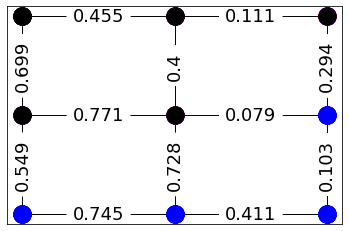

In [5]:
def random_ferromagnet(G, seed=None):
    np.random.seed(seed)

    J = nx.linalg.graphmatrix.adjacency_matrix(G).todense()
    H = np.random.rand(len(J), len(J))

    return np.multiply(J, (H + H.T) / 2)


G = nx.generators.lattice.grid_2d_graph(3, 3)
J = random_ferromagnet(G, seed=0)
cascade_gif(J, [2])